In [112]:
pip install umap-learn umap torch torchinfo csaps tslearn scikit-fda

Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.ml.torch.distributor import TorchDistributor 
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [60]:
import statsmodels.api as sm
import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import math
import os
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from torchinfo import summary
from scipy.interpolate import interp1d, BSpline, splrep
from csaps import csaps
from skfda.representation.interpolation import SplineInterpolation
from scipy.interpolate import UnivariateSpline
from tslearn.metrics import SoftDTWLossPyTorch
from torch.utils.data import DataLoader, TensorDataset
from scipy.spatial.distance import cdist
import seaborn as sns
from scipy import stats
import time as time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)
os.makedirs('./trained_networks/example', exist_ok=True) 

In [3]:
df_raw_data = pd.read_csv('../ECG5000/ecg.csv', header=None)
df_raw_data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [5]:
ecgs = df_raw_data.iloc[:, :-1].values
print(ecgs)

[[-0.11252183 -2.8272038  -3.7738969  ...  0.12343082  0.92528624
   0.19313742]
 [-1.1008778  -3.9968398  -4.2858426  ...  0.77381971  1.1196209
  -1.4362499 ]
 [-0.56708802 -2.5934502  -3.8742297  ...  0.32109663  0.90422673
  -0.42179659]
 ...
 [-1.1229693  -2.2529248  -2.8676281  ... -2.874136   -2.0083694
  -1.8083338 ]
 [-0.54770461 -1.8895451  -2.8397786  ...  1.261335    1.1504486
   0.80493225]
 [-1.3517791  -2.2090058  -2.5202247  ... -2.2600228  -1.577823
  -0.68453092]]


In [6]:
from sklearn.preprocessing import StandardScaler
scaled_ecgs = StandardScaler().fit_transform(ecgs)

In [7]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_ecgs)
embedding.shape

(4998, 2)

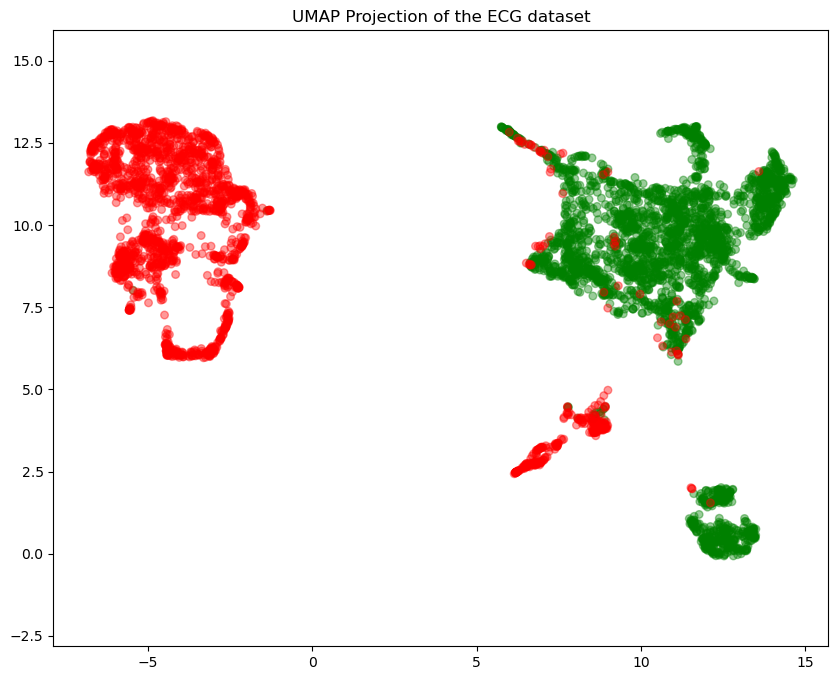

In [204]:
cmap = {0: 'r', 1: 'g'}
fig_umap = plt.figure(figsize=(10, 8))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[cmap[x] for x in df_raw_data.iloc[:, -1].astype(int)],
    alpha=0.4,
    s=30)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Projection of the ECG dataset');

fig_umap.savefig('latence_umap_v3.png', dpi=300, bbox_inches='tight')

In [10]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness

In [11]:
# Calculate trustworthiness
trust = trustworthiness(ecgs, embedding)
print(f"Trustworthiness: {trust}")

# Calculate pairwise distances
original_distances = pairwise_distances(ecgs)
reduced_distances = pairwise_distances(embedding)

# Calculate correlation between distances
correlation = np.corrcoef(original_distances.flatten(), reduced_distances.flatten())[0, 1]
print(f"Distance Correlation: {correlation}")

Trustworthiness: 0.9559628340314081
Distance Correlation: 0.766832318291625


In [12]:
random_SEED = 42
np.random.seed(random_SEED)

df_raw_data = pd.read_csv('../ECG5000/ecg.csv', header=None)
df_raw_data.columns = [f't{i+1}' for i in range(df_raw_data.shape[1] - 1)] + ['label'] # 4998x140 (+1 column for labels); 1: normal, 0: anomalous; 2079 normal
torch_data_normal = torch.tensor(df_raw_data[df_raw_data['label'] == True].values[:,:-1], dtype=torch.float32)
torch_data_anomalous = torch.tensor(df_raw_data[df_raw_data['label'] == False].values[:,:-1], dtype=torch.float32)
hold_out_idx = torch.tensor(random.sample(range(torch_data_normal.shape[0]), 500))
all_indices = torch.arange(torch_data_normal.shape[0])
remaining_indices = all_indices[~torch.isin(all_indices, hold_out_idx)]
hold_out_normal = torch_data_normal[hold_out_idx,:]
torch_data_normal = torch_data_normal[remaining_indices,:]
input_dim = torch_data_normal.shape[1]
print(f'input dimension is {input_dim}')
encoding_dim = 10

# # Uncomment to increment the size of the training data to see if the notebook is scalable
# torch_data_normal = torch.concat((torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,
#               torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,
#               torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal,torch_data_normal))

print(f'Training data (normal): {torch_data_normal.shape[0]}')
print(f'Anomalous data: {torch_data_anomalous.shape[0]}')
print(f'Hold-out data (normal): {hold_out_normal.shape[0]}')
print(f'Total data: {hold_out_normal.shape[0]+torch_data_anomalous.shape[0]+torch_data_normal.shape[0]}')

train_datasets = []

num_splits = 9
split_sizes = [torch_data_normal.shape[0] // num_splits] * (num_splits - 1) + [torch_data_normal.shape[0] - (torch_data_normal.shape[0] // num_splits) * (num_splits - 1)]
train_datasets = torch.split(torch_data_normal, split_sizes)
for tt_idx, tt in enumerate(train_datasets):
    print(f"{tt.shape[0]} data in chunk number {tt_idx+1}")

input dimension is 140
Training data (normal): 2419
Anomalous data: 2079
Hold-out data (normal): 500
Total data: 4998
268 data in chunk number 1
268 data in chunk number 2
268 data in chunk number 3
268 data in chunk number 4
268 data in chunk number 5
268 data in chunk number 6
268 data in chunk number 7
268 data in chunk number 8
275 data in chunk number 9


In [13]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded
    

models = []
for i in range(num_splits):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))

In [14]:
def train_data_loader(split_index, datasets, batch_size):
    """This function creates the dataloader for each node.

    Parameters
    ----------
    split_index : (int)
        The number of the assigned node (0,1,...)
    datasets : (list)
        A list of datasets
    batch_size : (int)
        Size of the minibatch

    Returns
    -------
    A dataloader for the dataset at index split_index
    """

    train_dataset_split_index = TensorDataset(datasets[split_index])
    train_dataloader_split_index = DataLoader(train_dataset_split_index, batch_size=batch_size, shuffle=True)
    
    return(train_dataloader_split_index)

def training(models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch):
    """This function creates the function for the torchdistributor to run.

    Parameters
    ----------
    models : [models]
        A list of models to be trained
    train_datasets : (list)
        A list of datasets to be used for training
    criterion : (function)
        Loss function
    num_epochs : (int)
        Number of epochs to be run
    batch_size : (int)
        Size of the minibatch
    learning_rate : (float)
        The learning rate for the optimizer
    print_epoch : (int)
        Determines if we print a loss and how often, set to 0 to omit print
    Returns
    -------
    empty return
    """

    
    local_rank = int(os.environ["LOCAL_RANK"])
    
    model = models[local_rank]
    
    dataloader = train_data_loader(local_rank, train_datasets, batch_size)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(1,num_epochs+1):
        total_loss = 0
        for batch in dataloader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if print_epoch != 0:
            if epoch % print_epoch == 0:
                print(f"Model {local_rank} Epoch [{epoch}/{num_epochs}], Loss: {total_loss/len(dataloader):.6f}")
    
    torch.save(model.state_dict(), "./trained_networks/example/ensemble_" + str(local_rank) + ".pth")

    # # Attempted this, but it doesn't update the list accordingly
    # models[local_rank] = model
    return 

In [15]:
criterion = nn.MSELoss()

num_epochs = 100
batch_size = 32
learning_rate = 0.01

print_epoch = 0

start_time = time.time()

# run takes arguments: (<function to be run>, <arguments to be passed to function>)
TorchDistributor(num_processes=num_splits, local_mode=True, use_gpu=False).run(training, # function to run
                models, train_datasets, criterion, num_epochs, batch_size, learning_rate, print_epoch) # arguments to pass to function

print('It took ' , time.time()-start_time ,'s')

Started local training with 9 processes
Finished local training with 9 processes


*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
*****************************************
It took  8.511573553085327 s


In [16]:
# Done at post-training, inference/evaluation
# Loads the trained models from the folder trained_networks/example
models = []
for i in range(num_splits):
    models.append(TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim))
    models[i].load_state_dict(torch.load("./trained_networks/example/ensemble_" + str(i) + ".pth", weights_only=True))
    models[i].eval()

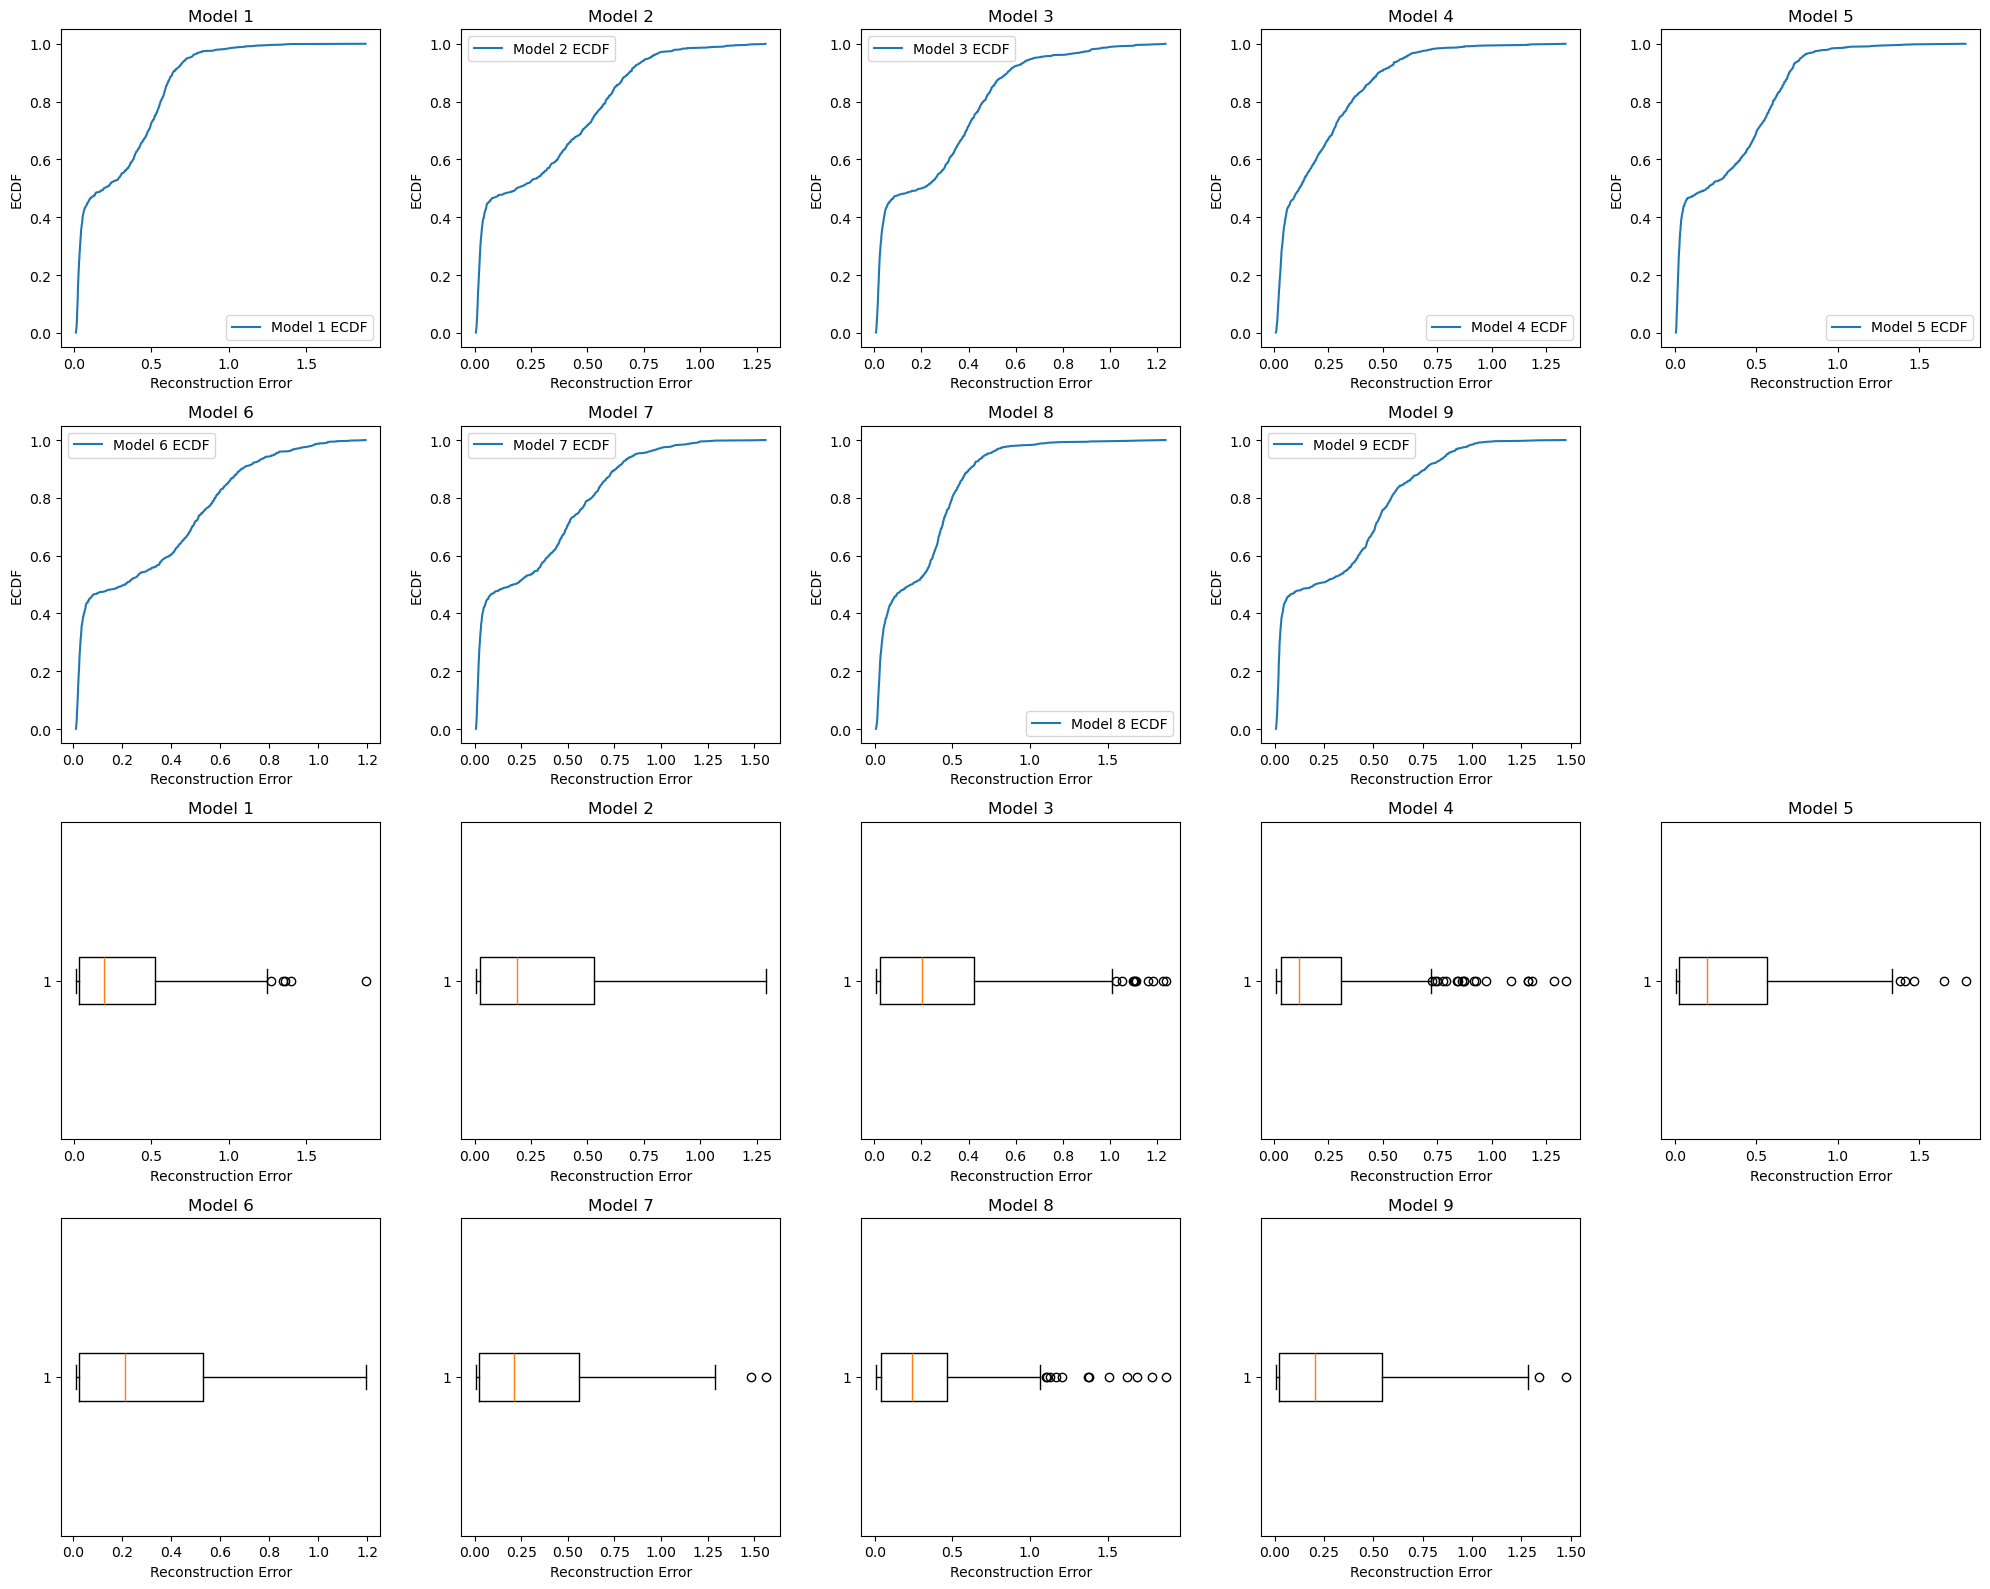

In [237]:
#STD method 
new_patients = torch.concat((hold_out_normal, torch_data_anomalous[torch.tensor(random.sample(range(torch_data_anomalous.shape[0]), 500)),:]))
true_labels = torch.concat((torch.ones(500), torch.zeros(500))).numpy()
mse_loss = nn.MSELoss()

reconstructed_new_patients_all = []
result_all = [] 
threshold_all = []
new_patients_loss_all = []
normal_loss_all = []

with torch.no_grad():
    fig_std, axs = plt.subplots(4, 5, figsize=(20, 16))
    for i in range(num_splits):
        i_model = models[i]
        i_model.eval()  
        reconstructed_new_patients_i = i_model(new_patients)
        reconstructed_new_patients_all.append(reconstructed_new_patients_i)
        new_patients_loss_i = []
        normal_loss_i = []
        for j in range(train_datasets[i].shape[0]):
            normal_loss_i.append(mse_loss(i_model(train_datasets[i][j,:]), train_datasets[i][j,:]).numpy())
        for j in range(new_patients.shape[0]):
            new_patients_loss_i.append(mse_loss(reconstructed_new_patients_i[j,:], new_patients[j,:]).numpy())
        normal_loss_all.append(np.array(normal_loss_i))
        new_patients_loss_all.append(np.array(new_patients_loss_i))
        new_patients_loss_ecdf_i = stats.ecdf(new_patients_loss_i)

        # plt.subplot(1, 9, i + 1)
        # # ax = plt.subplot()
        # ax.set_title('ECDF of New Patients MSE Loss')
        # ax.set_xlabel('MSE Loss Value')
        # ax.set_ylabel('ECDF')
        # # ax.legend([1,2,3,4,5,6,7,8,9])
        # new_patients_loss_ecdf_i.cdf.plot(ax)

        row = i // 5
        col = i % 5
        ecdf = sm.distributions.ECDF(new_patients_loss_i)
        axs[row, col].plot(ecdf.x, ecdf.y, label=f'Model {i+1} ECDF')
        axs[row, col].set_title(f'Model {i+1}')
        axs[row, col].set_xlabel('Reconstruction Error')
        axs[row, col].set_ylabel('ECDF')
        axs[row, col].legend()
        
        threshold_i = np.mean(normal_loss_i)
        std_i = np.std(normal_loss_i)
        lower_bound = threshold_i - 2 * std_i
        upper_bound = threshold_i + 2 * std_i

        row = (i // 5) + 2
        col = i % 5
        axs[row, col].boxplot(new_patients_loss_i, vert=False)
        axs[row, col].set_title(f'Model {i+1}')
        axs[row, col].set_xlabel('Reconstruction Error')
        
        threshold_all.append((lower_bound, threshold_i, upper_bound))
        # print(f'lower {i}: {lower_bound}, upper {i}: {upper_bound}')
        result_i = np.where((new_patients_loss_i < lower_bound) | (new_patients_loss_i > upper_bound), 0, 1)
        # result_size = len(result_i)
        # print(f'result_size {i}: {result_size}')
        # print(result_i)
        result_all.append(result_i)

    #surpress empty axs
    fig_std.delaxes(axs[1, 4])
    fig_std.delaxes(axs[3, 4])
 
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save the figure
    fig_std.savefig('training-std-ecdf-box-v3.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

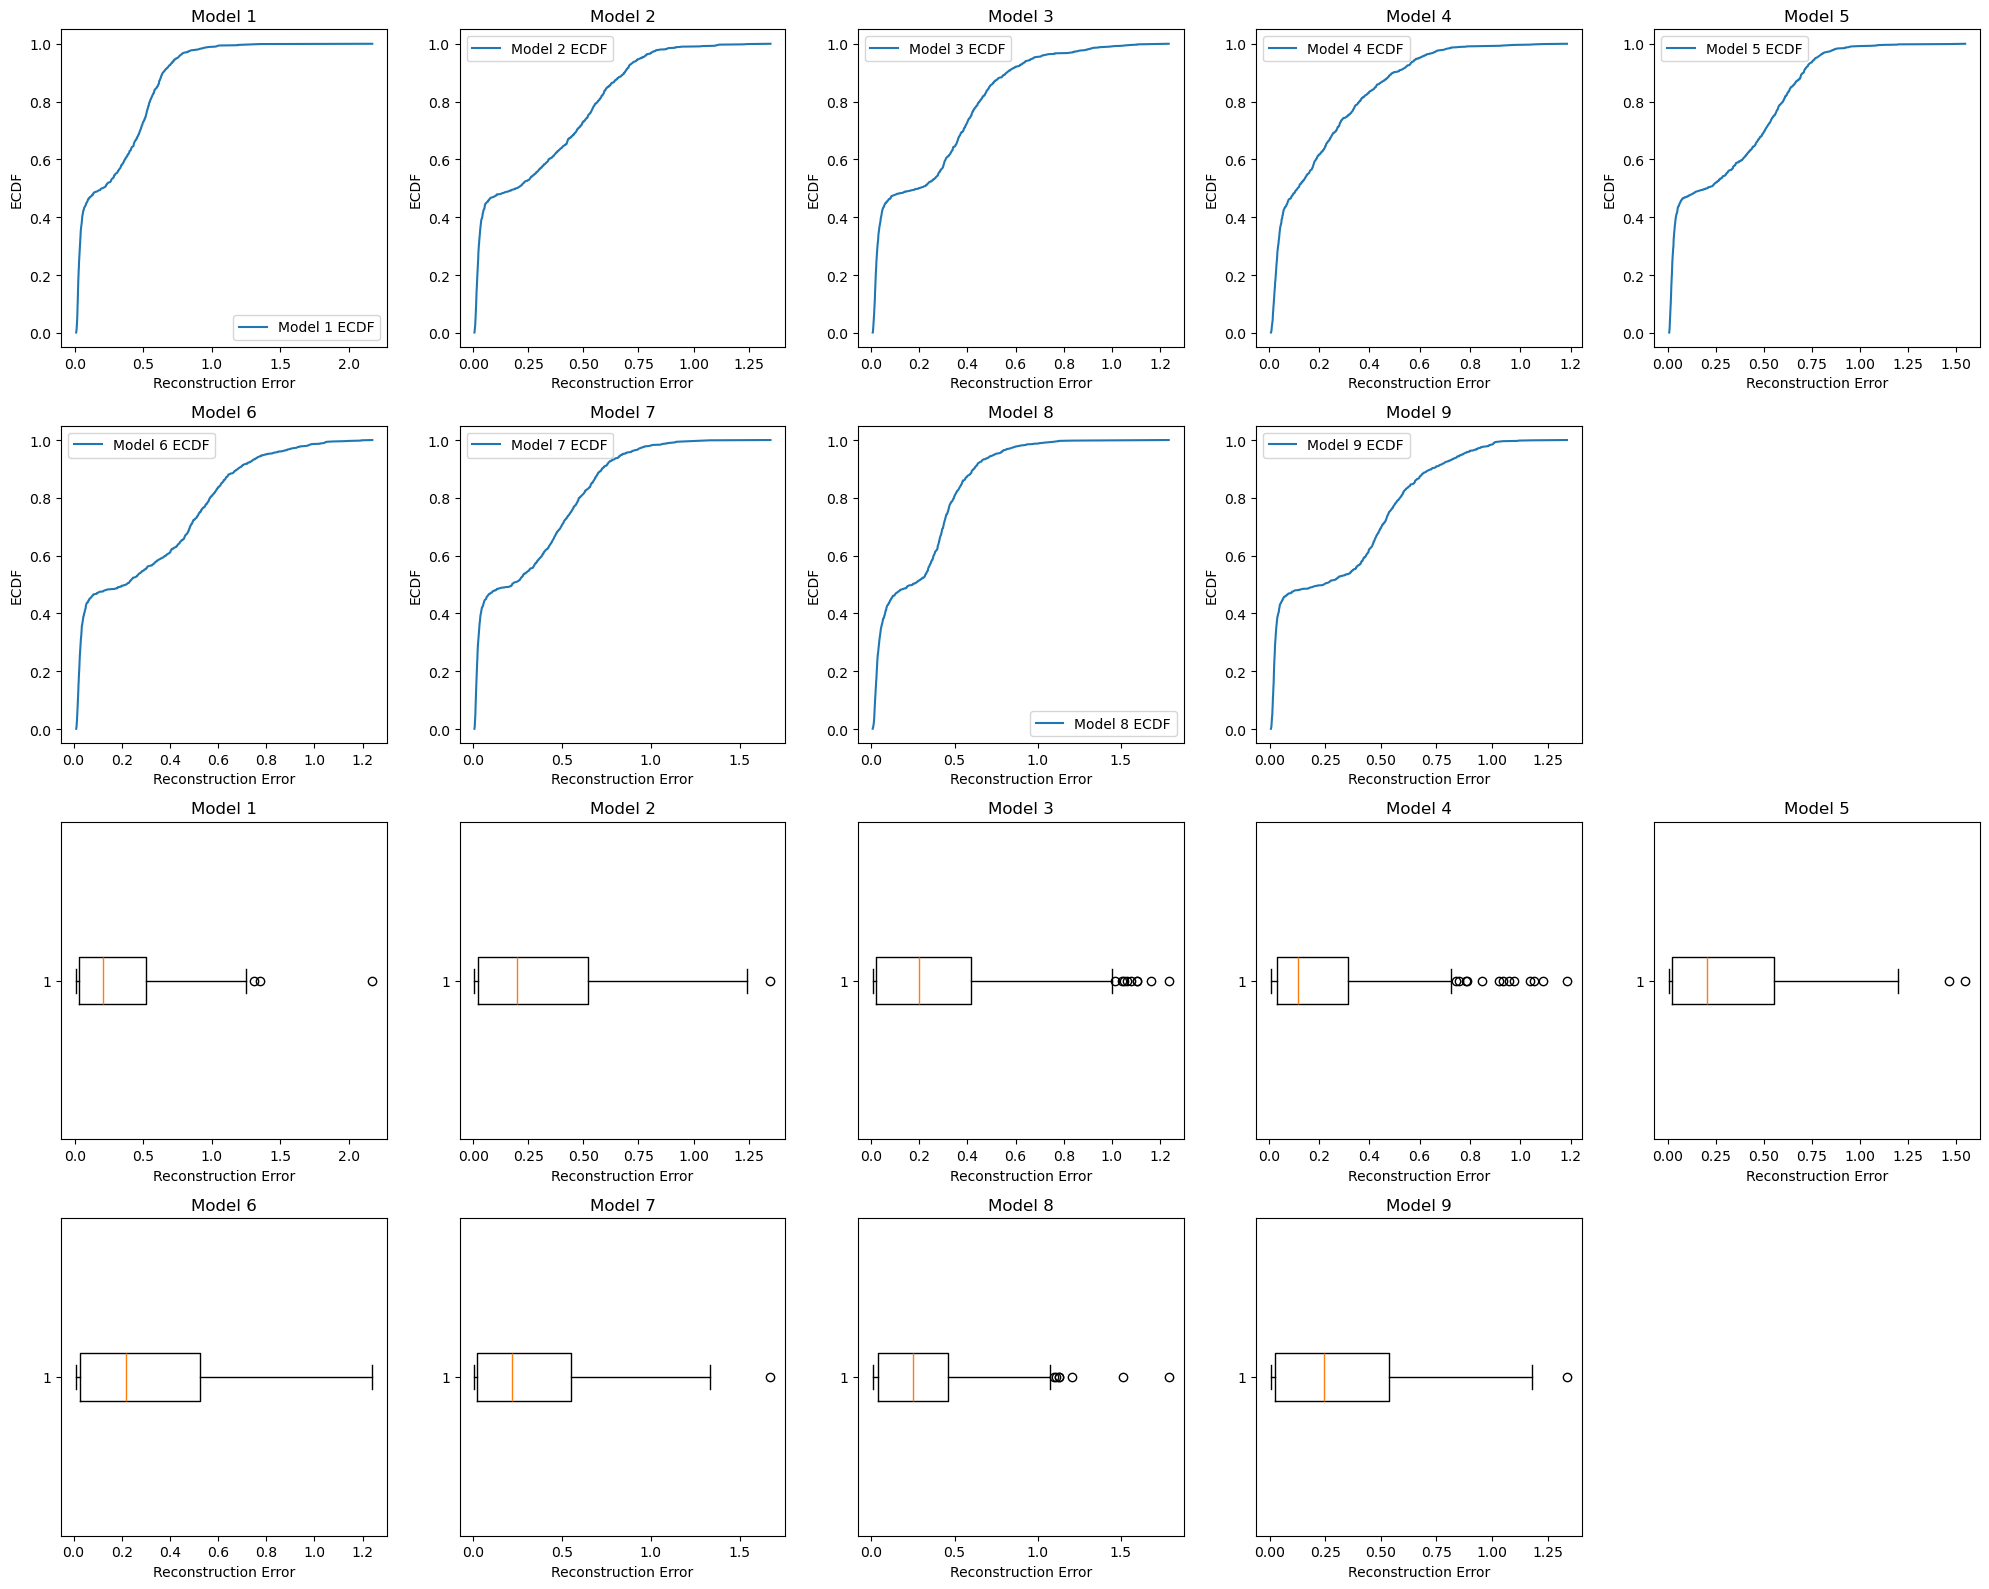

In [235]:
#IRP method 
new_patients = torch.concat((hold_out_normal, torch_data_anomalous[torch.tensor(random.sample(range(torch_data_anomalous.shape[0]), 500)),:]))
true_labels = torch.concat((torch.ones(500), torch.zeros(500))).numpy()
mse_loss = nn.MSELoss()

reconstructed_new_patients_all = []
result_all = [] 
threshold_all = []
new_patients_loss_all = []
normal_loss_all = []

with torch.no_grad():
    fig_iqr, axs = plt.subplots(4, 5, figsize=(20, 16))
    for i in range(num_splits):
        i_model = models[i]
        i_model.eval()  
        reconstructed_new_patients_i = i_model(new_patients)
        reconstructed_new_patients_all.append(reconstructed_new_patients_i)
        new_patients_loss_i = []
        normal_loss_i = []
        for j in range(train_datasets[i].shape[0]):
            normal_loss_i.append(mse_loss(i_model(train_datasets[i][j,:]), train_datasets[i][j,:]).numpy())
        for j in range(new_patients.shape[0]):
            new_patients_loss_i.append(mse_loss(reconstructed_new_patients_i[j,:], new_patients[j,:]).numpy())
        normal_loss_all.append(np.array(normal_loss_i))
        new_patients_loss_all.append(np.array(new_patients_loss_i))
        new_patients_loss_ecdf_i = stats.ecdf(new_patients_loss_i)

        # plt.subplot(1, 9, i + 1)
        # # ax = plt.subplot()
        # ax.set_title('ECDF of New Patients MSE Loss')
        # ax.set_xlabel('MSE Loss Value')
        # ax.set_ylabel('ECDF')
        # # ax.legend([1,2,3,4,5,6,7,8,9])
        # new_patients_loss_ecdf_i.cdf.plot(ax)

        row = i // 5
        col = i % 5
        ecdf = sm.distributions.ECDF(new_patients_loss_i)
        axs[row, col].plot(ecdf.x, ecdf.y, label=f'Model {i+1} ECDF')
        axs[row, col].set_title(f'Model {i+1}')
        axs[row, col].set_xlabel('Reconstruction Error')
        axs[row, col].set_ylabel('ECDF')
        axs[row, col].legend()
        
        threshold_i = np.mean(normal_loss_i)
        # std_i = np.std(normal_loss_i)
        # lower_bound = threshold_i - 2 * std_i
        # upper_bound = threshold_i + 2 * std_i
        q1 = np.percentile(normal_loss_i, 25)
        q3 = np.percentile(normal_loss_i, 75)
        IQR =  q3 - q1
        k = 1.8 #loose bound
        # k = 1 #tight bound
        lower_bound = q1 - k * IQR
        upper_bound = q3 + k * IQR

        row = (i // 5) + 2
        col = i % 5
        axs[row, col].boxplot(new_patients_loss_i, vert=False)
        axs[row, col].set_title(f'Model {i+1}')
        axs[row, col].set_xlabel('Reconstruction Error')
        
        threshold_all.append((lower_bound, threshold_i, upper_bound))
        # print(f'lower {i}: {lower_bound}, upper {i}: {upper_bound}')
        result_i = np.where((new_patients_loss_i < lower_bound) | (new_patients_loss_i > upper_bound), 0, 1)
        # result_size = len(result_i)
        # print(f'result_size {i}: {result_size}')
        # print(result_i)
        result_all.append(result_i)

    # #surpress empty axs
    fig_iqr.delaxes(axs[1, 4])
    fig_iqr.delaxes(axs[3, 4])
 
    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the figure
    fig_iqr.savefig('training-irq-ecdf-box-v3.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

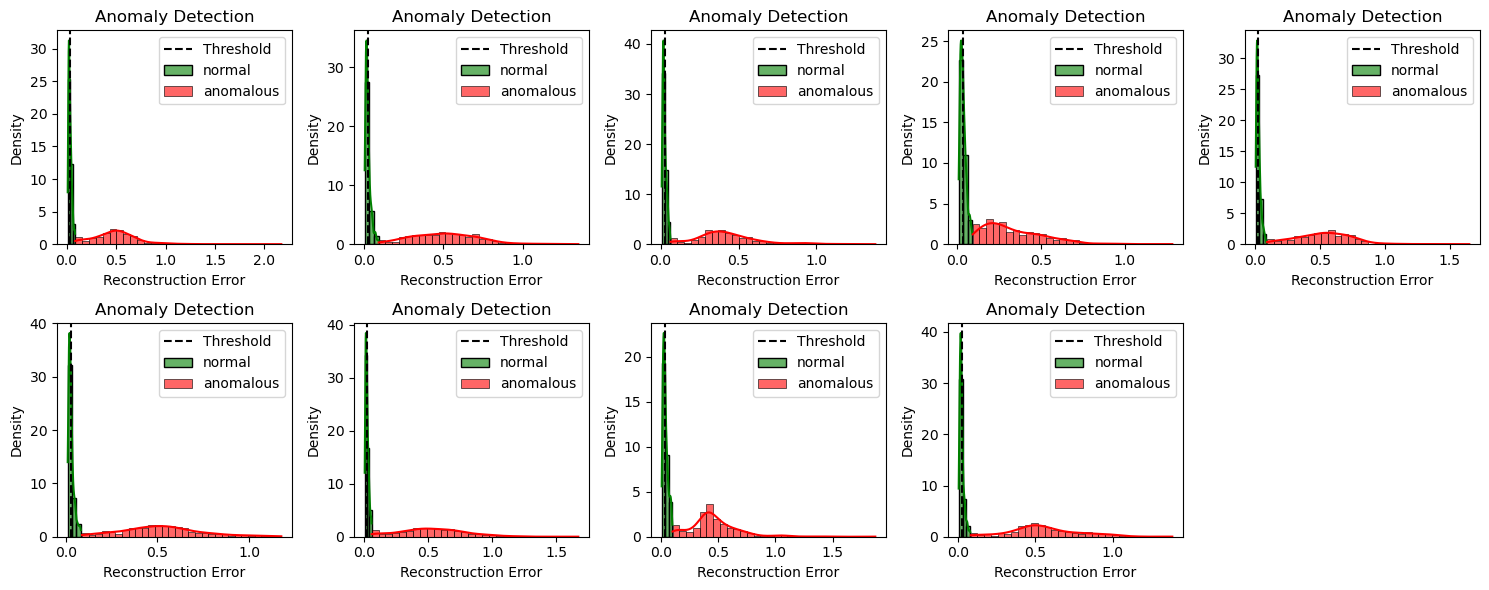

In [229]:
fig_q = plt.figure(figsize=(15, 6))  # Adjust figure size for side-by-side plots

for i in range(9):
    plt.subplot(2, 5, i + 1)  # Create 5 side-by-side subplots
    res = new_patients_loss_all[i]
    lower_bound, threshold, upper_bound = threshold_all[i]
    # print(res)
    normal = res[ (res >= lower_bound) & (res <= upper_bound)]
    # print(normal)
    anomalous = res[(res < lower_bound) | (res > upper_bound)]
    
    # Plot the histogram for data below the threshold
    sns.histplot(normal, bins=3, kde=True, color='green', alpha=0.6, stat='density', label='normal')
    
    # Plot the histogram for data above the threshold
    sns.histplot(anomalous, bins=30, kde=True, color='red', alpha=0.6, stat='density', label='anomalous')
    
    # Add a vertical line for the threshold
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')

    # Add labels and title
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.title('Anomaly Detection')
    plt.legend()

plt.tight_layout()
# Save the figure
fig_q.savefig('hist-threshold-v3.png', dpi=300, bbox_inches='tight')
plt.show()

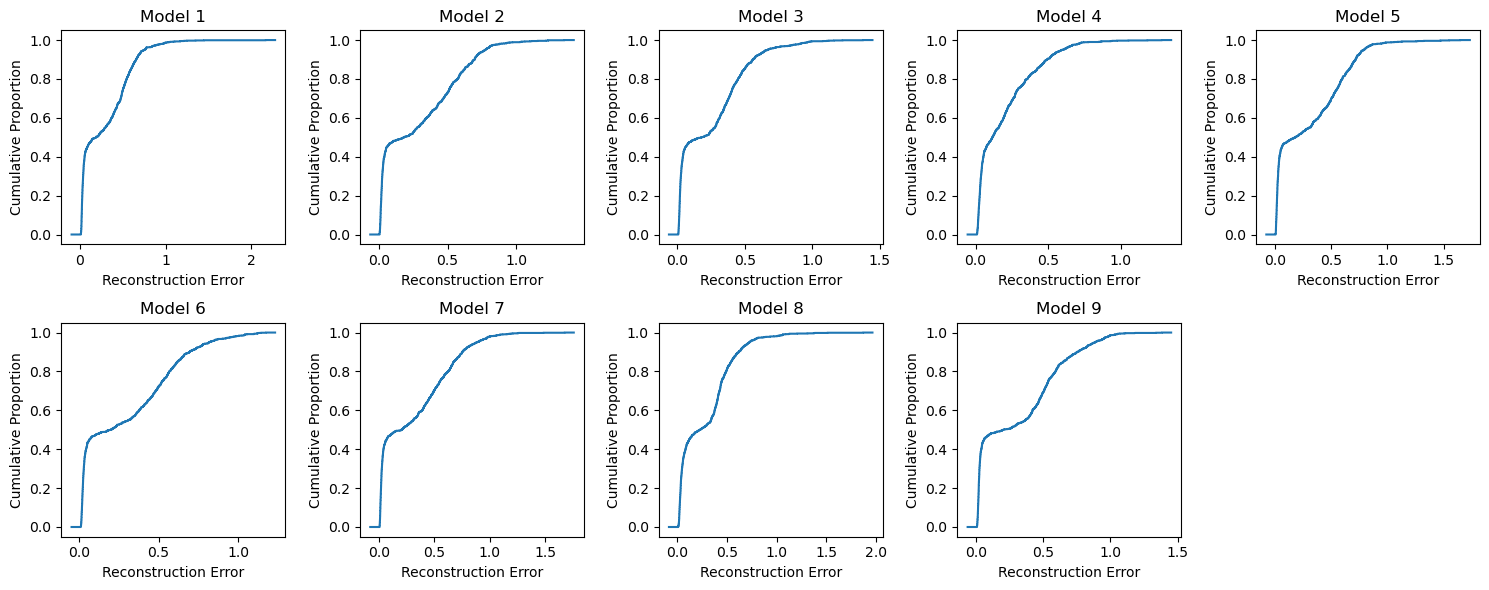

In [224]:
fig_c = plt.figure(figsize=(15, 6))  # Adjust figure size for side-by-side plots

for i in range(9):
    ax = plt.subplot(2, 5, i + 1)  # Create 5 side-by-side subplots

    # Extract the ECDF data for the current model
    ecdf_i = stats.ecdf(new_patients_loss_all[i])
    lower_bound, threshold, upper_bound = threshold_all[i]
    ecdf_i.cdf.plot(ax)

    plt.title(f"Model {i + 1}")
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Cumulative Proportion')

plt.tight_layout()
# Save the figure
fig_c.savefig('cdf-cumulative-v3.png', dpi=300, bbox_inches='tight')
plt.show()

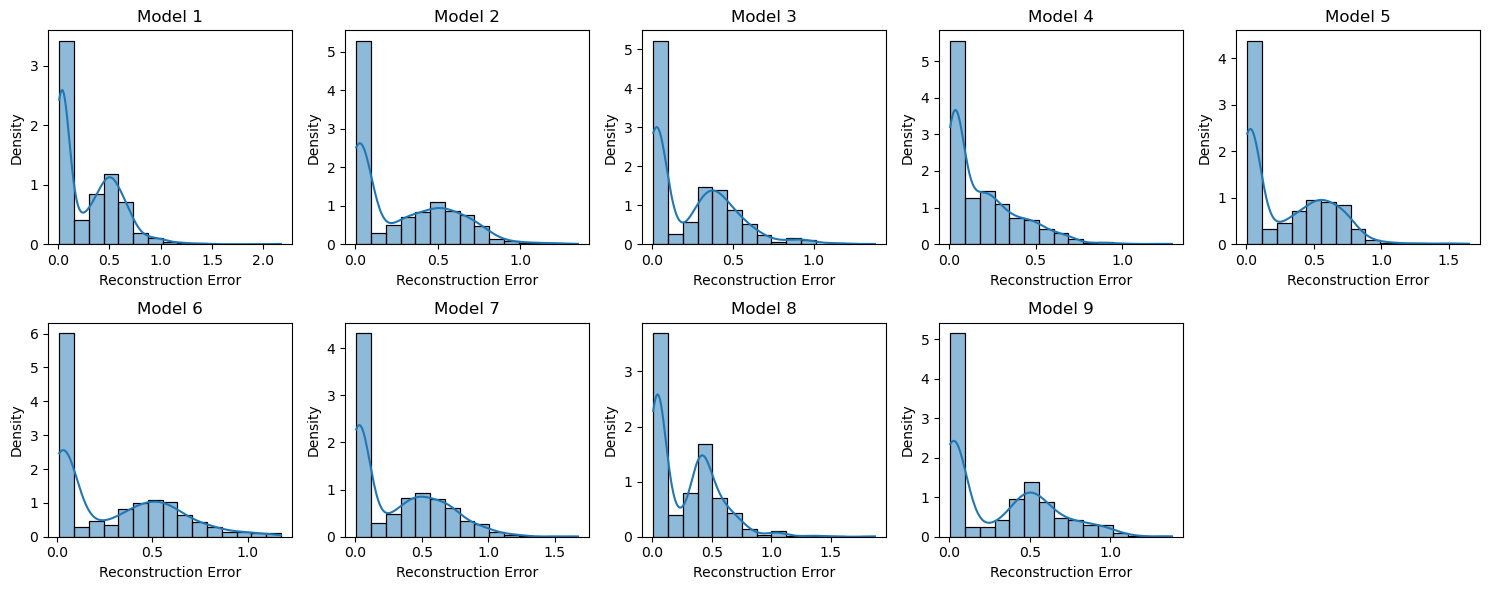

In [223]:
fig_e = plt.figure(figsize=(15, 6))  # Adjust figure size for side-by-side plots

for i in range(9):
    plt.subplot(2, 5, i + 1)  # Create 5 side-by-side subplots

    sns.histplot(data=new_patients_loss_all[i], bins=15, stat='density', kde=True)

    plt.title(f"Model {i + 1}")
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')

plt.tight_layout()
# Save the figure
fig_e.savefig('hist-kde-v3.png', dpi=300, bbox_inches='tight')
plt.show()

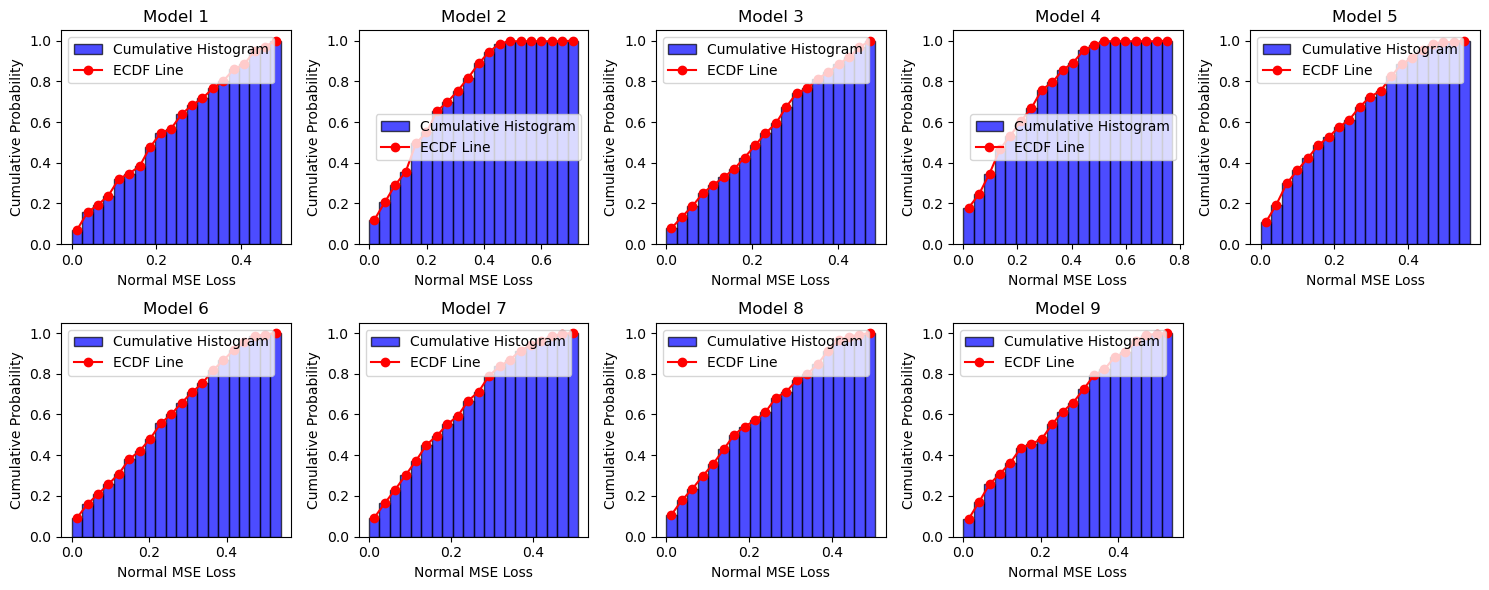

In [220]:
fig = plt.figure(figsize=(15, 6))  # Adjust figure size for side-by-side plots

for i in range(9):
    plt.subplot(2, 5, i + 1)  # Create 5 side-by-side subplots

    # Extract the ECDF data for the current model
    ecdf_i = stats.ecdf(new_patients_loss_all[i])
    # lower_bound, threshold, upper_bound = threshold_all[i]
    # thresholds = np.full(1000, threshold)
    thresholds = normal_loss_all[i]
    ecdf_values = ecdf_i.cdf.evaluate(thresholds)
    
    # Plot cumulative histogram
    counts, bins, _ = plt.hist(
        ecdf_values,
        bins=20,  # Adjust number of bins as needed
        cumulative=True,
        color='blue',
        alpha=0.7,
        edgecolor='black',
        density=True,  # Normalize for ECDF-like visualization
        label="Cumulative Histogram"
    )

    # Calculate the midpoints of bins for the cumulative line
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Plot the cumulative ECDF line
    plt.plot(
        bin_centers,
        counts,
        marker='o',
        color='red',
        label="ECDF Line"
    )

    plt.title(f"Model {i + 1}")
    plt.xlabel('Normal MSE Loss')
    plt.ylabel('Cumulative Probability')
    plt.legend()

plt.tight_layout()
# Save the figure
fig.savefig('ecdf-cumulative-histogam-v3.png', dpi=300, bbox_inches='tight')
plt.show()

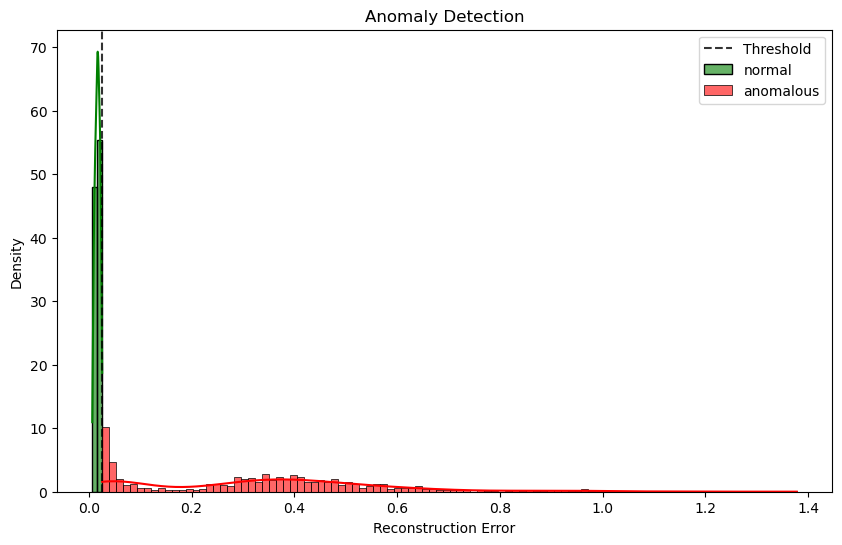

In [216]:
#naive threshold
res = new_patients_loss_all[2]
lower_bound, threshold, upper_bound = threshold_all[2]
# print(res)
normal = res[ (res <= threshold)]
# print(normal)
anomalous = res[res > threshold]
fig_mse = plt.figure(figsize=(10, 6))

# Plot the histogram for data below the threshold
sns.histplot(normal, bins=2, kde=True, color='green', alpha=0.6, stat='density', label='normal')

# Plot the histogram for data above the threshold
sns.histplot(anomalous, bins=100, kde=True, color='red', alpha=0.6, stat='density', label='anomalous')

# Add a vertical line for the threshold
plt.axvline(threshold, color='black', linestyle='--', alpha=0.8, label='Threshold')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Anomaly Detection')
plt.legend()

# Show the plot
fig_mse.savefig('mse-histogam-density-v3.png', dpi=300, bbox_inches='tight')
plt.show()

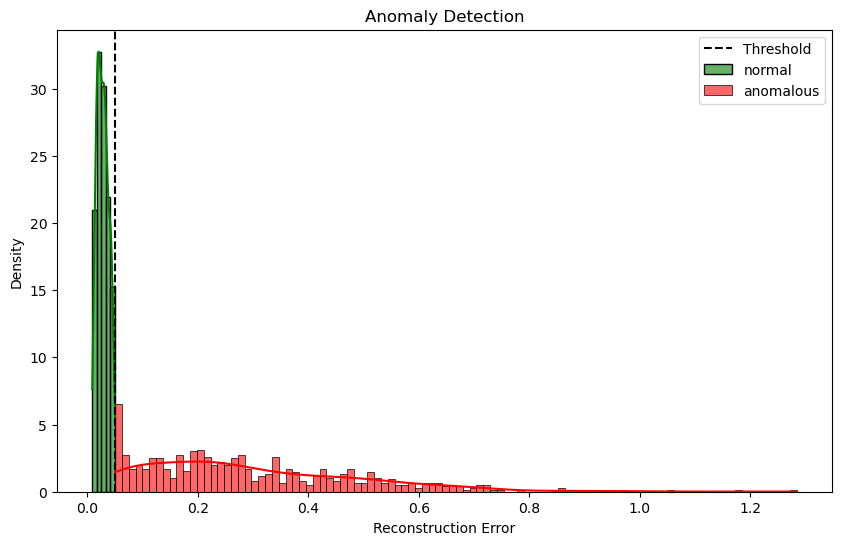

In [218]:
#seemingly golden threshold
threshold = 0.05
res = new_patients_loss_all[3]
normal = res[res <= threshold]
anomalous = res[res > threshold]

fig1 = plt.figure(figsize=(10, 6))

# Plot the histogram for data below the threshold
sns.histplot(normal, bins=5, kde=True, color='green', alpha=0.6, stat='density', label='normal')

# Plot the histogram for data above the threshold
sns.histplot(anomalous, bins=100, kde=True, color='red', alpha=0.6, stat='density', label='anomalous')

# Add a vertical line for the threshold
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Anomaly Detection')
plt.legend()

# Show the plot
fig1.savefig('recon-histogam-density-v3.png', dpi=300, bbox_inches='tight')
plt.show()

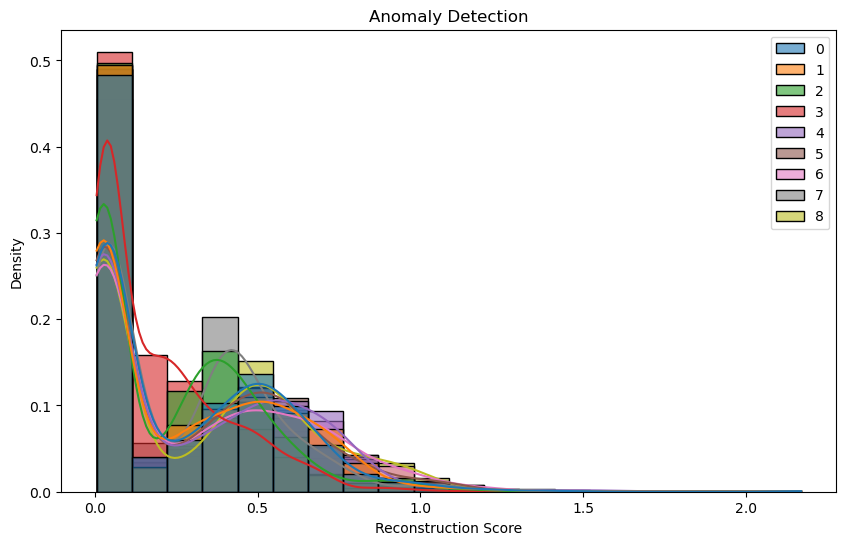

In [211]:
fig_k = plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(new_patients_loss_all, bins=20, kde=True, color='blue', alpha=0.6, stat='density')

# Add labels and title
plt.xlabel('Reconstruction Score')
plt.ylabel('Density')
plt.title('Anomaly Detection')

# Show the plot
fig_k.savefig('recon-histogam-density-kde-v3.png', dpi=300, bbox_inches='tight')
plt.show()

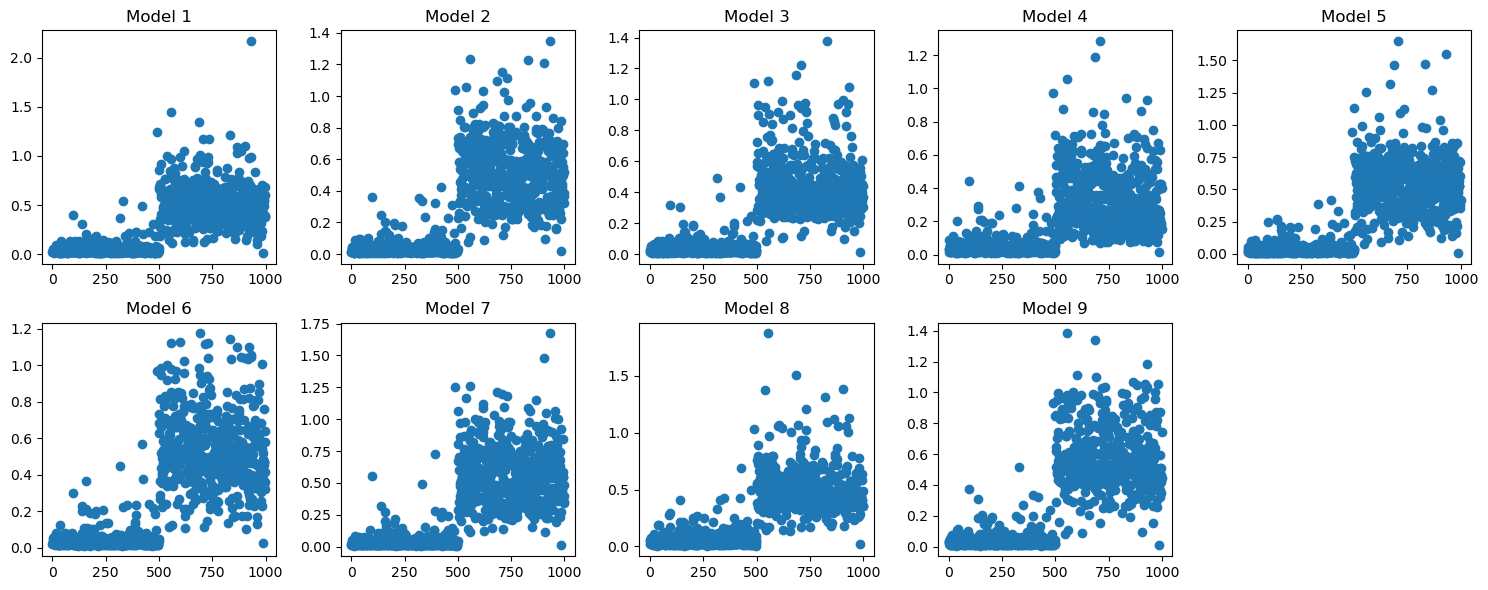

In [209]:
fig_s = plt.figure(figsize=(15, 6))  # Adjust figure size for side-by-side plots
for i in range(9):
    plt.subplot(2, 5, i + 1)  # Create 5 side-by-side subplots
    plt.scatter(range(len(new_patients_loss_all[i])), new_patients_loss_all[i])
    # plt.plot(range(len(result_all[i])), result_all[i])
    plt.title(f"Model {i+1}")
plt.tight_layout()
fig_s.savefig('recon-scatter-v3.png', dpi=300, bbox_inches='tight')
plt.show()

In [238]:
cm_all = []
accuracy_all = []
precision_all = []
recall_all = []
# 
for i in range(num_splits):
    # print(true_labels)
    # print(np.count_nonzero(true_labels))
    predicted_labels_i = result_all[i]
    # print(np.count_nonzero(predicted_labels_i))
    # print(len(predicted_labels_i) - np.count_nonzero(predicted_labels_i))
    cm_i = confusion_matrix(true_labels, predicted_labels_i)
    cm_all.append(cm_i)

    print(f"Confusion Matrix from model {i+1}:")
    print(cm_i)

    accuracy_i = accuracy_score(true_labels, predicted_labels_i)
    accuracy_all.append(accuracy_i)
    precision_i = precision_score(true_labels, predicted_labels_i)
    precision_all.append(precision_i)
    recall_i = recall_score(true_labels, predicted_labels_i)
    recall_all.append(recall_i)

    print(f"Accuracy from model {i+1}: {accuracy_i}")
    print(f"Precision from model {i+1}: {precision_i}")
    print(f"Recall from model {i+1}: {recall_i}")

Confusion Matrix from model 1:
[[500   0]
 [ 51 449]]
Accuracy from model 1: 0.949
Precision from model 1: 1.0
Recall from model 1: 0.898
Confusion Matrix from model 2:
[[500   0]
 [ 31 469]]
Accuracy from model 2: 0.969
Precision from model 2: 1.0
Recall from model 2: 0.938
Confusion Matrix from model 3:
[[500   0]
 [ 50 450]]
Accuracy from model 3: 0.95
Precision from model 3: 1.0
Recall from model 3: 0.9
Confusion Matrix from model 4:
[[489  11]
 [ 43 457]]
Accuracy from model 4: 0.946
Precision from model 4: 0.9764957264957265
Recall from model 4: 0.914
Confusion Matrix from model 5:
[[500   0]
 [ 32 468]]
Accuracy from model 5: 0.968
Precision from model 5: 1.0
Recall from model 5: 0.936
Confusion Matrix from model 6:
[[500   0]
 [ 34 466]]
Accuracy from model 6: 0.966
Precision from model 6: 1.0
Recall from model 6: 0.932
Confusion Matrix from model 7:
[[500   0]
 [ 61 439]]
Accuracy from model 7: 0.939
Precision from model 7: 1.0
Recall from model 7: 0.878
Confusion Matrix from 

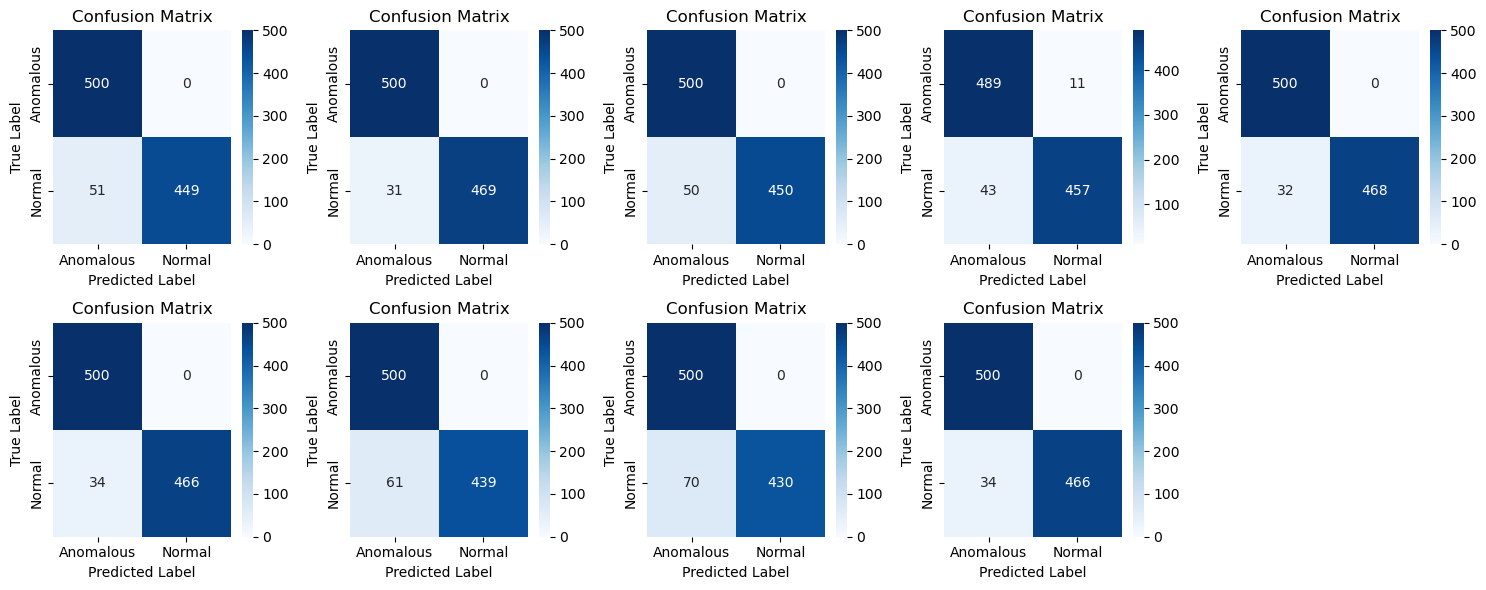

In [239]:
fig_cm = plt.figure(figsize=(15, 6))
# Create a heatmap
x_class_names = ['Anomalous', 'Normal']
y_class_names = ['Anomalous', 'Normal']
for i in range(num_splits):
    plt.subplot(2, 5, i+1)
    sns.heatmap(cm_all[i], annot=True, fmt="d", cmap="Blues", xticklabels=x_class_names, yticklabels=y_class_names)
    
    # Add labels and title
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
plt.tight_layout()
fig_cm.savefig('recon-cm-v3.png', dpi=300, bbox_inches='tight')
plt.show()